<a href="https://colab.research.google.com/github/JayNguyen-123/Video_Classification_CNN_LSTM/blob/main/Video_Classification_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A 3D-CNN-LSTM vision encoder is a deep learning model that processes video sequences by extracting spatial features (using 3D CNNs) and modeling temporal relationships across the spatial features using LSTMs. This is commonly used in action recognition and video classification tasks.

This architecture consists of:

1. 3D convolutional layers (extract spatial features from video frames).

2. Flattening and temporal processing with LSTM (model sequential relationships across the video frames).

3. Fully connected layers for video classification.

In [12]:
import cv2
import torch
import numpy as np
from torchvision import transforms

def video_sampler(video_path, num_frames=16, frame_size=(112, 112)):
    # from video load random nframes
    cap = cv2.VideoCapture(video_path)
    frames = []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = np.linspace(0, total_frames-1, num_frames).astype(int)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(frame_size),
        transforms.ToTensor(),
    ])

    for idx in frame_idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(transform(frame))

    cap.release()

    if len(frames) < num_frames:
        frames += [frames[-1]] * (num_frames - len(frames))

    return torch.stack(frames)  # Shape: (T, C, H, W)


In [13]:

import torch.nn as nn

class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        self.conv3d = nn.Sequential(
            nn.Conv3d(in_channels=3, out_channels=64, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3, 3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2))
        )

    def forward(self, x):
        return self.conv3d(x)  # Shape: (Batch, 128, T//2, H//4, W//4)

# Example forward pass
model_3dcnn = CNN3D()


In [14]:
class LSTMVisionEncoder(nn.Module):
    def __init__(self, cnn3d, hidden_size=256, num_classes=2):
        super(LSTMVisionEncoder, self).__init__()
        self.cnn3d = cnn3d
        self.hidden_size = hidden_size
        # The input_size should be 128 * 28 * 28,
        # which is the feature dimension of each frame after the CNN3D
        self.lstm = nn.LSTM(input_size=128*28*28, hidden_size=hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, y=None):
        batch_size, C, frames, H, W = x.shape

        # Pass through 3D CNN backbone
        x = self.cnn3d(x)  # Output shape: (batch, 128, T//2, H//4, W//4)

        # Reshape to (batch_size, frames//2, 128*28*28) before feeding into LSTM
        x = x.view(batch_size, frames // 2, -1) # Reshape to match LSTM input

        # LSTM forward pass
        lstm_out, _ = self.lstm(x)  # (batch, frames, lstm_hidden_size)

        # Take the last frame's output for classification
        output = self.fc(lstm_out[:, -1, :])  # (batch, num_classes)

        return output

# Initialize model
model = LSTMVisionEncoder(model_3dcnn)

### Kinetic400-tinny dataset
- Let train our model with a small, light weight dataset with Kinetic400-tiny dataset.
- Class 0 is a demonstration of rope climbing, while class 1 is a demonstration of welding. So let’s go ahead to build a binary classification model (2 classes).

In [15]:
!pip install decord

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import decord
import pandas as pd
from decord import VideoReader, cpu
import torchvision.transforms as transforms
import os

# Define VideoDataset class
class KineticsTinyDataset(Dataset):
    def __init__(self, root_dir, data_dir, num_frames=16, frame_size=(112, 112)):
        self.root_dir = root_dir
        self.data_dir = data_dir
        self.video_files, self.labels = self._load_data()
        self.num_frames = num_frames
        self.frame_size = frame_size
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(self.frame_size),
            transforms.ToTensor()
        ])

    def _load_data(self):

        df = pd.read_csv(self.data_dir, delimiter='\t', names=['video_info'])  # Assumes comma-separated values
        x,y = [], []
        for index, row in df.iterrows():
          video_name, video_class = row['video_info'].split(' ')
          x.append(video_name)
          y.append(int(video_class))

        return x,y

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = os.path.join(self.root_dir, self.video_files[idx])
        label = self.labels[idx]
        vr = VideoReader(video_path, ctx=cpu(0))

        # Select frames evenly spaced
        total_frames = len(vr)
        frame_idxs = torch.linspace(0, total_frames-1, self.num_frames).long().tolist()
        frames = [vr[i].asnumpy() for i in frame_idxs]
        if self.transform:
          frames = [self.transform(frame) for frame in frames]

        frames = torch.stack(frames)  # (T, C, H, W)
        return frames, torch.tensor(label)  # (C, T, H, W) .permute(1, 0, 2, 3)


root_dir = "/content/sample_data/train"
annotation = "/content/kinetics_tiny_train_video.txt"

# Load dataset
train_dataset = KineticsTinyDataset(root_dir, annotation)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

# Check dataset output
sample_video, sample_label = train_dataset[20]
print("Sample Video Shape:", sample_video.shape)  # Expected: (3, 16, 112, 112)
print("Sample Label:", sample_label)



Sample Video Shape: torch.Size([16, 3, 112, 112])
Sample Label: tensor(0)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1, Loss: 0.7964
Epoch 2, Loss: 0.6944
Epoch 3, Loss: 0.6965
Epoch 4, Loss: 0.6930
Epoch 5, Loss: 0.6801
Epoch 6, Loss: 0.6766
Epoch 7, Loss: 0.6561
Epoch 8, Loss: 0.6411
Epoch 9, Loss: 0.6083
Epoch 10, Loss: 0.5491
Epoch 11, Loss: 0.5616
Epoch 12, Loss: 0.3671
Epoch 13, Loss: 0.3717
Epoch 14, Loss: 0.2446
Epoch 15, Loss: 0.1558
Epoch 16, Loss: 0.1238
Epoch 17, Loss: 0.0996
Epoch 18, Loss: 0.0497
Epoch 19, Loss: 0.0293
Epoch 20, Loss: 0.0187


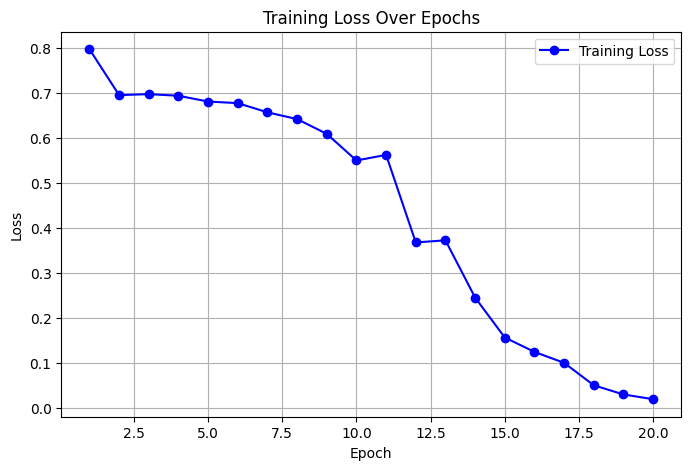

In [16]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Store loss values for plotting
loss_history = []

# Training Loop
for epoch in range(20):
    epoch_loss = 0  # Track loss for the epoch
    num_batches = 0

    for videos, labels in train_loader:
        videos, labels = videos.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(videos.permute(0, 2, 1, 3, 4), labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches  # Compute average loss
    loss_history.append(avg_loss)  # Store for plotting
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# Plot the loss curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), loss_history, marker="o", linestyle="-", color="b", label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()




In [17]:
# Inference
import torch.nn.functional as F

root_dir = "/content/sample_data/val"
annotation = "/content/kinetics_tiny_val_video.txt"

val_dataset = KineticsTinyDataset(root_dir, annotation)
sample_video, sample_label = train_dataset[3]
class_labels = [0, 1]

def predict(video_tensor, label):
  print("Expected class: ", class_labels[label.item()])
  with torch.no_grad():
    output = model(video_tensor.permute(0, 2, 1, 3, 4), label)
    probabilities = F.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

  print(f"Predicted Class: {class_labels[predicted_class]} ({probabilities.max().item():.4f} confidence)")

predict(sample_video.unsqueeze(0).to(device), sample_label.to(device))




Expected class:  1
Predicted Class: 1 (0.9991 confidence)
